# Forecasting with ML 📉

One disadvantage of using ARIMA models is that they are linear. Hence they will underfit in situations where the underlying data is of non-linear form.

One piece of recent open software is facebook's `prophet`. This uses a model which is similar to a **generalised additive model** (GAM), a class of additive (linear) models with potentially non-linear components. You can read more about the underlying model [here](https://peerj.com/preprints/3190/).

As you are beginning to see time series forecasting can sometimes be as much an art as a science, and we know it takes quite some practice to become a good artist. The authors of the software had this in mind when they wrote it.  One of their aims is to provide software which can be used easily by those who have a little timeseries knowledge. Let's see how this goes....We will apply this software to the airline data now.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style

#! conda install -c conda-forge fbprophet

# Example 1 - airline data

We setup the data as we had done so before in the ARIMA example.

In [4]:
# !pip install pmdarima

     |████████████████████████████████| 138 kB 2.7 MB/s eta 0:00:01


In [2]:
from pmdarima.datasets import load_airpassengers

START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

#there's no datetimeindex from the bundled dataset. So let's add one.
airline.index= pd.date_range(START_DATE, periods=len(airline), freq='MS')

In [3]:
def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data
    
    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series
    
    Returns:
    --------
    tuple (len=2) 
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    '''
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

In [4]:
#for cv need all of the training data joined together.
airline_adj = airline / airline.index.days_in_month

train, test = ts_train_test_split(airline_adj, '1960-01-01')
train_log, test_log = np.log(train), np.log(test) # get logged values for arima model


## Forecasting with prophet

Fitting a basic model and making predictions is very simple with `prophet`.

In [5]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters() # required to fix plotting bug introduced by prophet

Importing plotly failed. Interactive plots will not work.


Training data is expected in this df format below.

In [8]:
train

1949-01-01     3.612903
1949-02-01     4.214286
1949-03-01     4.258065
1949-04-01     4.300000
1949-05-01     3.903226
                ...    
1959-08-01    18.032258
1959-09-01    15.433333
1959-10-01    13.129032
1959-11-01    12.066667
1959-12-01    13.064516
Freq: MS, Length: 132, dtype: float64

In [6]:
train_df = pd.DataFrame(train).reset_index().rename(columns = {0:'y','index':'ds'})

In [7]:
train_df.tail()

,ds,y
127,1959-08-01,18.032258
128,1959-09-01,15.433333
129,1959-10-01,13.129032
130,1959-11-01,12.066667
131,1959-12-01,13.064516


Fit model...

In [9]:
model = Prophet()
model.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Make predictions...

In [10]:
future = model.make_future_dataframe(periods=12, freq='MS', include_history=True) #create a dataframe with the prediction datetimes we want
future.head()

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01


In [11]:
forecast = model.predict(future)
y_pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

In [12]:
y_pred

,yhat,yhat_lower,yhat_upper
ds,,,
1949-01-01,2.657704,1.857627,3.520912
1949-02-01,3.164883,2.292589,4.012333
1949-03-01,3.687220,2.873277,4.490197
1949-04-01,3.736369,2.914085,4.551557
1949-05-01,3.555718,2.714111,4.393814
...,...,...,...
1960-08-01,17.069468,16.288543,17.870349
1960-09-01,16.094747,15.303739,16.904702
1960-10-01,14.754471,13.925436,15.590788


In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,3.600599,1.857627,3.520912,3.600599,3.600599,-0.942895,-0.942895,-0.942895,-0.942895,-0.942895,-0.942895,0.0,0.0,0.0,2.657704
1,1949-02-01,3.670719,2.292589,4.012333,3.670719,3.670719,-0.505836,-0.505836,-0.505836,-0.505836,-0.505836,-0.505836,0.0,0.0,0.0,3.164883
2,1949-03-01,3.734053,2.873277,4.490197,3.734053,3.734053,-0.046833,-0.046833,-0.046833,-0.046833,-0.046833,-0.046833,0.0,0.0,0.0,3.687220
3,1949-04-01,3.804172,2.914085,4.551557,3.804172,3.804172,-0.067803,-0.067803,-0.067803,-0.067803,-0.067803,-0.067803,0.0,0.0,0.0,3.736369
4,1949-05-01,3.872030,2.714111,4.393814,3.872030,3.872030,-0.316312,-0.316312,-0.316312,-0.316312,-0.316312,-0.316312,0.0,0.0,0.0,3.555718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,15.364654,16.288543,17.870349,15.354880,15.374333,1.704814,1.704814,1.704814,1.704814,1.704814,1.704814,0.0,0.0,0.0,17.069468
140,1960-09-01,15.463749,15.303739,16.904702,15.451504,15.475326,0.630998,0.630998,0.630998,0.630998,0.630998,0.630998,0.0,0.0,0.0,16.094747
141,1960-10-01,15.559647,13.925436,15.590788,15.545040,15.573088,-0.805175,-0.805175,-0.805175,-0.805175,-0.805175,-0.805175,0.0,0.0,0.0,14.754471
142,1960-11-01,15.658741,13.184317,14.745215,15.641676,15.674649,-1.617444,-1.617444,-1.617444,-1.617444,-1.617444,-1.617444,0.0,0.0,0.0,14.041297


Plot predictions...

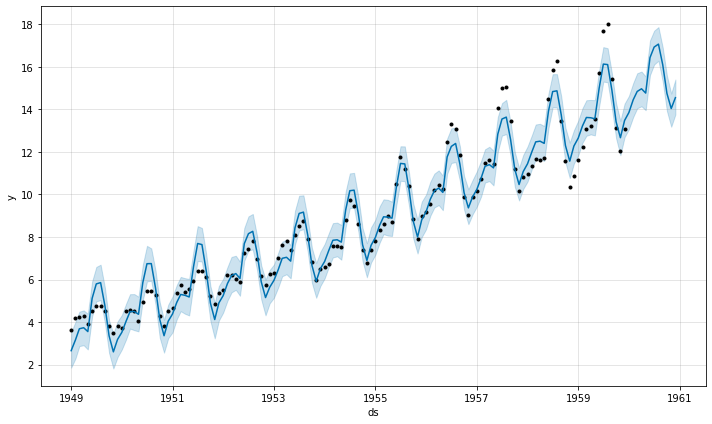

In [17]:
fig = model.plot(forecast)
# test.plot(style='.r')

Evaluating this baseline model error on test set...

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    MAPE

    Parameters:
    --------
    y_true -- np.array actual observations from time series
    y_pred -- the predictions to evaluate

    Returns:
    -------
    float, scalar value representing the MAPE (0-100)
    '''
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
mean_absolute_percentage_error(test.values , forecast['yhat'][-12:])

6.656999855761518

We at least see it beats the naive model scores  that we saw in the last notebook (from the unlogged data). Not bad for only several lines of code. But looking at the plot it is clearly not fitting well. We should use cross validation to find a better fitting model (before we evaluated in the test set!).

## Cross validation in prophet

There are cross validation functions in `prophet` that take care of time series data and can perform adjustable rolling windows as we had previously seen in other time series cross validation functions.

In [18]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [19]:
365.25*4

1461.0

In [20]:
model = Prophet()
model.fit(train_df)
df_cv = cross_validation(model, initial='1461 days', period='365 days', horizon = '365 days')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 1953-12-02 00:00:00 and 1958-12-01 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1954-01-01,7.374734,7.111772,7.632618,6.580645,1953-12-02
1,1954-02-01,8.073018,7.815829,8.339350,6.714286,1953-12-02
2,1954-03-01,8.316081,8.027725,8.578564,7.580645,1953-12-02
3,1954-04-01,8.248502,7.996782,8.511875,7.566667,1953-12-02
4,1954-05-01,8.062861,7.787160,8.324561,7.548387,1953-12-02


A function for performance metrics and plotting...

In [22]:
df_p = performance_metrics(df_cv)

In [23]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,61 days,0.731749,0.855423,0.708125,0.079015,0.071685,0.380952
1,62 days,0.900625,0.949012,0.825101,0.085354,0.086172,0.285714
2,89 days,0.744382,0.862776,0.713703,0.075617,0.086172,0.333333
3,90 days,0.574954,0.758257,0.584116,0.054702,0.041338,0.571429
4,120 days,0.471565,0.686706,0.544250,0.054785,0.050609,0.500000


In [24]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,61 days,0.731749,0.855423,0.708125,0.079015,0.071685,0.380952
1,62 days,0.900625,0.949012,0.825101,0.085354,0.086172,0.285714
2,89 days,0.744382,0.862776,0.713703,0.075617,0.086172,0.333333
3,90 days,0.574954,0.758257,0.584116,0.054702,0.041338,0.571429
4,120 days,0.471565,0.686706,0.544250,0.054785,0.050609,0.500000
5,121 days,0.579008,0.760926,0.596340,0.056887,0.050609,0.535714
6,150 days,0.493886,0.702770,0.543208,0.053867,0.036859,0.571429
7,151 days,0.406926,0.637908,0.449142,0.043255,0.024620,0.678571
8,181 days,0.579037,0.760944,0.519201,0.049256,0.024620,0.642857
9,182 days,0.929637,0.964177,0.783182,0.062932,0.047160,0.535714


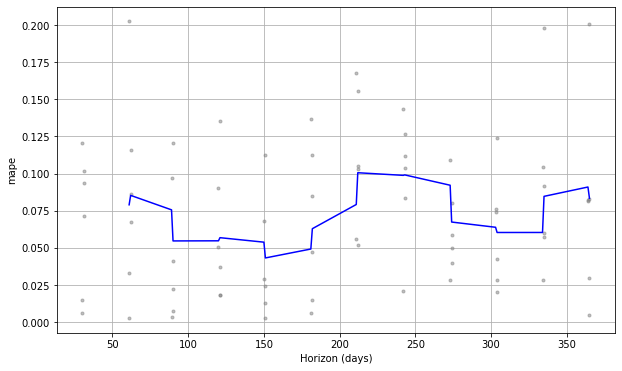

In [23]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

The plot above is the standard output plot of the CV from `prophet`. It is different to what we have looked at before. Each grey point represents a prediction, made on a particular month. Because we made predictions over several horizons each are plotted on the graph. At around horizon 30 for example we see each of the plots over the first month of each of the 6, 12 month validations. The blue line shows a rolling window of the mape scores 'averaged' over the cv predictions. More info [here](https://facebook.github.io/prophet/docs/diagnostics.html).

We are normally interested in the mean and std of the MAPE scores found at each window. This can be calculated from the dataframe returned from the `cross_validation` function above, using the function below. 

In [24]:
def mape_performance_calc(df_cv):
    " function to replace prophet cv 'performance metrics' function"
    df_cv['mape'] = abs(df_cv['y'] - df_cv['yhat']) /df_cv['y'] # make column with individual abs normalised values
    results = df_cv.groupby(['cutoff']).mean() # finish mape calc for each of the folds (distinguised in 'cutoff' column of df_cv)
    results = results.describe() # sumarise folds information
    results = results['mape']# # return only mape column
    return(results)

mape_performance_calc(df_cv)

count    6.000000
mean     0.072154
std      0.020667
min      0.052698
25%      0.059283
50%      0.066481
75%      0.077062
max      0.109789
Name: mape, dtype: float64

We find a MAPE of ~7.2% with std ~2%. This would have estimated the error we saw on the test set to a good degree.

## Hyper-parameters

The model plot we saw earlier did not fit very well to the train data. We can change the model assumptions (like hyper-parameters) to change how well it is fitting the train data.

`Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
)`

**TASK**

* Try changing some of these. [This](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) blog is very useful in explaining the parameters and what they do.
* Find at least one change which improves your model cross validation score

In [25]:
#### your solution here 






# Exercise 1 - energy data forecasting ⚡

Forecasting energy demand is big business and very important in helping energy producers maintain the balance within the electrical grid. You can find forecasts of energy demands for France in realtime [here](https://www.rte-france.com/fr/eco2mix/eco2mix-consommation). 

Your mission now is to imagine a useful use-case for an enterprise and use `Prophet` to make forecasts on the energy data you have already seen (in data viz module) for France! Feel free to choose :
* the type of energy generation/consommation
* france or regional,
* frequency scale you wish to try!

Try and consider a forecast horizon that seems useful for the frequency at which you are making your predictions e.g. predicting the hourly forecast for 12 months propbably cannot be used in any meaningful way - and is probably not going be very easy to forecast accurately.

Consider that:
* Reducing the scale of the data, i.e. to regional
* Higher frequency predictions
* longer periods of forecast

...are likely to make it more difficult to make a good forecast.

Consider also that you must pick the most suitable cross validation procedure for your problem. Consider the initial, step and horizon you will use carefully.

Once you have made your model:
1. Compare it to a naive model!! If it does not beat this then try reducing your forecast horizon to find at what scale you can make useful predictions.
2. Try tuning the model in some way to improve performance (add holidays might be a good idea)
3. If you have time compare your model to an ARIMA model. Why might there be differences in perfomance between the two approachecs to forecasting?

(feel free to use a new notebook for this task!)